In [108]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [109]:
df = pd.read_csv("german_credit_results.csv")

In [110]:
df.head()

,exp_type,random_distance,num_models,data_scale,random_seed,model_type,task_type,accuracy,acceptance,fairness_spd,fairness_eop,method,systemic_success,systemic_failure,multiplicity,failure_rate,homogenization_expected_failure,homogenization_avg_failure
0,baseline,0.0,1,10,0,logistic,is_good_loan,0.710,0.020,-0.031250,-0.060606,inaccurate,0.710,0.290,5.551115e-17,0.290,1.0,0.295918
1,baseline,0.0,1,10,0,logistic,is_good_loan,0.710,0.020,-0.031250,-0.060606,lockout,0.020,0.980,0.000000e+00,0.980,1.0,1.000000
2,baseline,0.1,1,10,0,logistic,is_good_loan,0.710,0.020,-0.031250,-0.060606,inaccurate,0.710,0.290,5.551115e-17,0.290,1.0,0.295918
3,baseline,0.1,1,10,0,logistic,is_good_loan,0.710,0.020,-0.031250,-0.060606,lockout,0.020,0.980,0.000000e+00,0.980,1.0,1.000000
4,baseline,0.2,1,10,0,logistic,is_good_loan,0.665,0.085,-0.024306,-0.050909,inaccurate,0.665,0.335,-5.551115e-17,0.335,1.0,0.366120


In [111]:
N_TRAIN = 800
metric = "systemic_failure"
method = "lockout"
xaxis, xaxis_label = "num_models", "Number of Models"

In [112]:
df = df[df["method"]==method]
df["data_scale"] = N_TRAIN/df["data_scale"]
df = df[["exp_type", "random_distance", xaxis, metric]]
df = df.groupby(["exp_type", "random_distance", xaxis]).mean().reset_index(drop=False)

In [113]:
def plot(df, metric, ylog=False, ylim=None):
    plt.rcParams["figure.figsize"] = [7,3]
    fig, ax = plt.subplots()
    plt.plot(df.loc[df["random_distance"]==0, xaxis], df.loc[df["random_distance"]==0, metric], '*-', color='#00060e', label="Threshold")
    plt.plot(df.loc[df["random_distance"]==0.1, xaxis], df.loc[df["random_distance"]==0.1, metric], '*-', color='#001e49', label="Random(0.4,0.6)")
    plt.plot(df.loc[df["random_distance"]==0.2, xaxis], df.loc[df["random_distance"]==0.2, metric], '*-', color='#002f70', label="Random(0.3,0.7)")
    plt.plot(df.loc[df["random_distance"]==0.3, xaxis], df.loc[df["random_distance"]==0.3, metric], '*-', color='#003f97', label="Random(0.2,0.8)")
    plt.plot(df.loc[df["random_distance"]==0.4, xaxis], df.loc[df["random_distance"]==0.4, metric], '*-', color='#004fbf', label="Random(0.1,0.9)")
    plt.plot(df.loc[df["random_distance"]==0.5, xaxis], df.loc[df["random_distance"]==0.5, metric], '*-', color='#0068f9', label="All Random")
  
    if ylim:
        plt.ylim(ylim)
    if ylog:
        plt.yscale('log')   

    plt.xlabel(xaxis_label)
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.tight_layout()
    plt.show()

# Baseline: Same Model + Data + Task

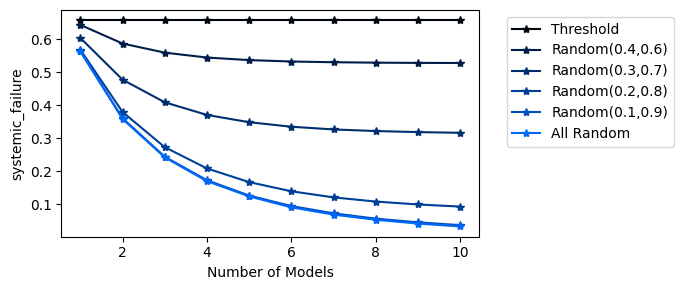

In [114]:
curr = df[df["exp_type"]=="baseline"].reset_index(drop=True)
plot(curr, metric)

# Baseline: Different Data Partitions

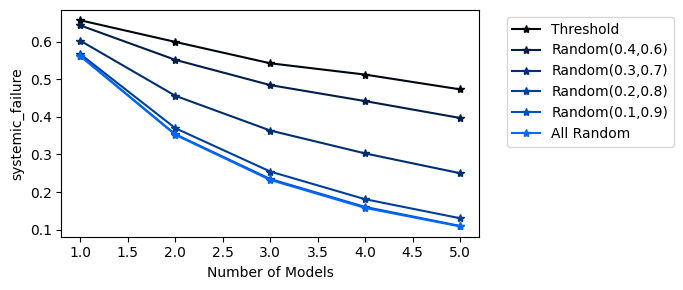

In [115]:
curr = df[df["exp_type"]=="data_partitions"].reset_index(drop=True)
plot(curr, metric)

# Baseline: Different Model Classes

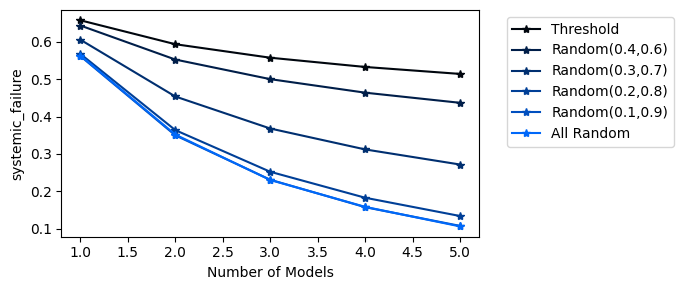

In [116]:
curr = df[df["exp_type"]=="models"].reset_index(drop=True)
plot(curr, metric)

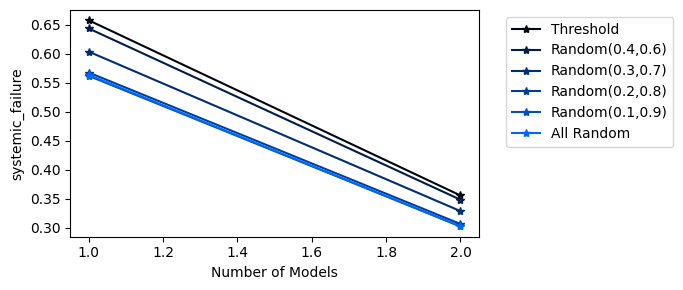

In [117]:
# Baseline: Different Prediction Tasks 
curr = df[df["exp_type"]=="tasks"].reset_index(drop=True)
plot(curr, metric)